# Lab 3 — dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import random
from bokeh.models import Legend, LegendItem
from sklearn.manifold import TSNE
import pyspark.sql as f

from operator import itemgetter
%config IPCompleter.greedy=True
%matplotlib inline
plt.style.use("ggplot")

In [2]:
import pickle
from matplotlib.colors import rgb2hex 
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

In [3]:
from sklearn.preprocessing import scale # Data scaling
from sklearn import decomposition #PCA
import pandas as pd

In [4]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [5]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

In [6]:
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 2

{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}


#### Exercise 3.1

In this exercise we analyse the variance and eigenvalues of our data in order to have an idea of how could be the dimensional reduction.

In [7]:
data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
movieRate = data.map(itemgetter("tagId", "movieId", "relevance" ))

In [8]:
# how many tags there are?
data.map(itemgetter('tagId')).distinct().count()

1128

In [9]:
data.map(itemgetter('tagId')).sortBy(lambda x: x).distinct().max()

1128

Now we now that we have a total of 1128 tags and that they range from 1 to 1128. 

First, we sort our data by the pair `tagId` and `movieId`. So, later, it will be easier to create the matrix.

In [10]:
tuples = movieRate.sortBy(lambda k: (k[0],k[1]), ascending=True).collect()

In [11]:
tuples_array = np.array(tuples)

Now, we have our Numpy array with 3 columns: tagId, movieId and relevance. Now we need to create the final matrix from this array.

In [12]:
tuples_array

array([[1.00000e+00, 1.00000e+00, 2.50000e-02],
       [1.00000e+00, 2.00000e+00, 3.97500e-02],
       [1.00000e+00, 3.00000e+00, 4.35000e-02],
       ...,
       [1.12800e+03, 1.31013e+05, 1.62500e-02],
       [1.12800e+03, 1.31168e+05, 1.72500e-02],
       [1.12800e+03, 1.31170e+05, 2.17500e-02]])

We create a matrix M x N, where M is the number of tags and N the number of movies.

In [13]:
unique_tags   = np.unique(tuples_array[:,0])
unique_movies = np.unique(tuples_array[:,1])

assert len(unique_tags)*len(unique_movies) == len(tuples_array) 
print(f'We have {len(unique_tags)} tags and {len(unique_movies)} movies.')

We have 1128 tags and 10381 movies.


So, in our matrix we have 1128 tags (columns) for each movie.

In [14]:
relevances = tuples_array[:,2].reshape(len(unique_tags),len(unique_movies))
relevances

array([[0.025  , 0.03975, 0.0435 , ..., 0.042  , 0.05975, 0.05325],
       [0.025  , 0.04375, 0.05475, ..., 0.03175, 0.10375, 0.08625],
       [0.05775, 0.03775, 0.028  , ..., 0.017  , 0.1785 , 0.017  ],
       ...,
       [0.03625, 0.01475, 0.0195 , ..., 0.0095 , 0.51925, 0.01575],
       [0.07775, 0.09025, 0.097  , ..., 0.0755 , 0.067  , 0.1145 ],
       [0.023  , 0.01875, 0.0185 , ..., 0.01625, 0.01725, 0.02175]])

In [15]:
relevances_df = pd.DataFrame(relevances, columns=unique_movies, index=unique_tags)

In [16]:
relevances_df

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,130075.0,130087.0,130490.0,130496.0,130520.0,130578.0,130840.0,131013.0,131168.0,131170.0
1.0,0.02500,0.03975,0.04350,0.03725,0.04200,0.02825,0.04575,0.03075,0.03500,0.99975,...,0.03150,0.05925,0.02700,0.03275,0.05875,0.15400,0.02400,0.04200,0.05975,0.05325
2.0,0.02500,0.04375,0.05475,0.03950,0.05275,0.02550,0.05275,0.03550,0.04050,0.99975,...,0.03650,0.05700,0.02575,0.03000,0.02325,0.04025,0.03025,0.03175,0.10375,0.08625
3.0,0.05775,0.03775,0.02800,0.03675,0.05925,0.01850,0.16675,0.04675,0.01825,0.01950,...,0.11300,0.01850,0.03825,0.02400,0.02150,0.01975,0.02425,0.01700,0.17850,0.01700
4.0,0.09675,0.04800,0.07700,0.03100,0.03675,0.04550,0.08275,0.02175,0.01800,0.03675,...,0.07475,0.03725,0.03525,0.02375,0.04425,0.01850,0.09375,0.05600,0.14875,0.02650
5.0,0.14675,0.11025,0.05400,0.06825,0.07525,0.09575,0.11450,0.05600,0.03650,0.06675,...,0.06800,0.05050,0.04975,0.06400,0.05000,0.02850,0.05600,0.05750,0.27750,0.15700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124.0,0.04150,0.02250,0.03675,0.05925,0.02075,0.15525,0.04875,0.02825,0.02225,0.03750,...,0.16875,0.07975,0.12075,0.06875,0.06500,0.02375,0.10775,0.10750,0.03225,0.58775
1125.0,0.01925,0.01550,0.01700,0.01500,0.01650,0.03525,0.01975,0.01675,0.01100,0.01775,...,0.01825,0.02325,0.00925,0.05100,0.01775,0.04225,0.06200,0.02500,0.04800,0.01075
1126.0,0.03625,0.01475,0.01950,0.01525,0.01675,0.01950,0.01050,0.01125,0.00700,0.01775,...,0.01425,0.01375,0.00875,0.00825,0.00850,0.00525,0.00775,0.00950,0.51925,0.01575
1127.0,0.07775,0.09025,0.09700,0.06450,0.10750,0.06650,0.10925,0.07000,0.07275,0.07300,...,0.09650,0.06350,0.11700,0.09050,0.06650,0.07575,0.27000,0.07550,0.06700,0.11450


Now, we compute and plot the variance of each tag. So we calculate the variance along the tag axis. We are interested in finding the tags that have more variability in the data.

In [17]:
var_rel = np.var(relevances,axis=1)

Text(0, 0.5, 'Variance')

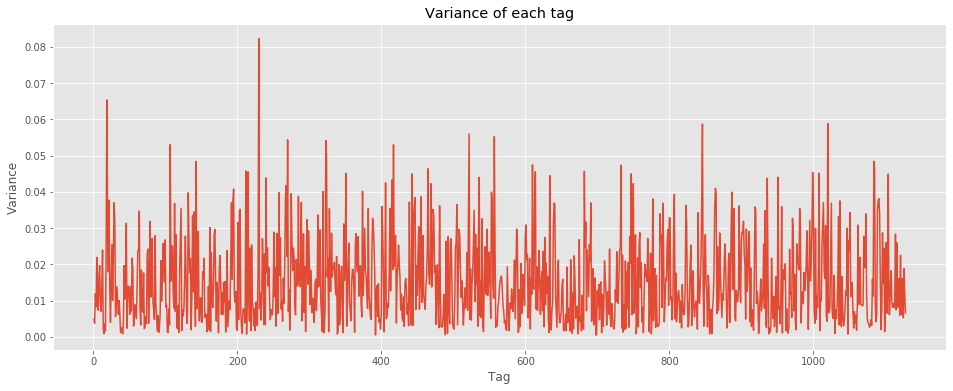

In [18]:
plt.figure(figsize=(16,6))
plt.plot(unique_tags,var_rel)
plt.title('Variance of each tag')
plt.xlabel('Tag'); plt.ylabel('Variance')

As we can see there are some tags that have more variance than others. So it's very probable that this tags will provide us more useful information than others that have lower variance values.

We want to reduce the dimensional space of our data but keeping as much variance as possible. To do that, we want to compute which are the directions in which the data has the most variance. In order to do that we will do the following:

First, we compute the covariance matrix of the data, but before we substract the mean of each tag, in order to normalize .

In [19]:
mean_rel = np.mean(relevances,axis=1)
cov_matrix = np.cov(relevances - mean_rel.reshape(-1,1))

In [20]:
cov_matrix

array([[ 0.00490042,  0.00327346, -0.00030115, ...,  0.00016838,
        -0.00016172, -0.00014599],
       [ 0.00327346,  0.00374098, -0.00023234, ...,  0.00011866,
        -0.00015645, -0.00014514],
       [-0.00030115, -0.00023234,  0.01184989, ...,  0.00130349,
        -0.00112118, -0.00035662],
       ...,
       [ 0.00016838,  0.00011866,  0.00130349, ...,  0.0188282 ,
        -0.00114338, -0.00032847],
       [-0.00016172, -0.00015645, -0.00112118, ..., -0.00114338,
         0.01105378,  0.00659333],
       [-0.00014599, -0.00014514, -0.00035662, ..., -0.00032847,
         0.00659333,  0.00658031]])

We check that our covariance matrix has the shape of M x M, where M is the number of tags.

In [21]:
cov_matrix.shape

(1128, 1128)

Now, we compute the eigenvalues of the covariance matrix we just computed.

The eigenvalues will tell us how the eigenvectors keep the variance from the original data.

In [22]:
eig_val,eig_vect = np.linalg.eigh(cov_matrix)
eig_val

array([5.49031633e-05, 7.85936871e-05, 1.21317789e-04, ...,
       9.96051519e-01, 1.22147104e+00, 2.75337748e+00])

In [23]:
idxs = np.argsort(eig_val)[::-1]    # eigenvalues index sorted by value (desc.)
eig_val_sort = eig_val[idxs]        # we take the eigenvalues sorted

Text(0, 0.5, 'eigenvalue')

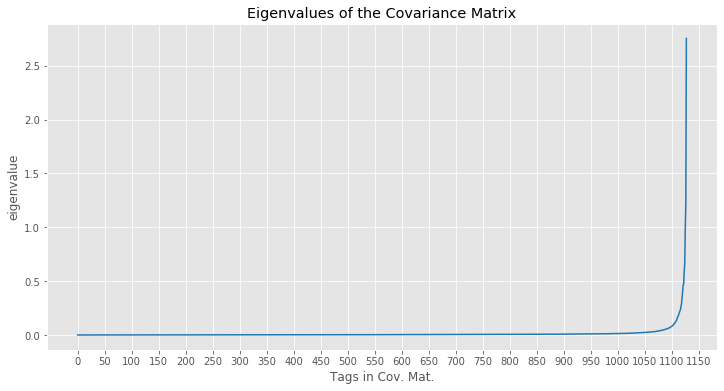

In [24]:
plt.figure(figsize=(12,6))
plt.plot(eig_val,color='tab:blue')
plt.title('Eigenvalues of the Covariance Matrix')
plt.xticks(range(0,1200,50))
plt.xlabel('Tags in Cov. Mat.'); plt.ylabel('eigenvalue')

The eigenvalues of the covariance matrix encode the variability of the data in an orthogonal basis. The corresponding eigenvectors represents a principal direction, and as higher is the eigenvalue of the eigenvector it will keep more variance from the original data in the new low-dimensional space. 

The whole set of eigenvectors keep all the original variance but we would not reduce the dimensional space, so we are interested in take a X set of eigenvectors that keep a certain % of the original variance..

Let's see how many directions (eigenvectors) we need to keep the 66% of the original variance.

In [25]:
# Capturing 2/3 of the variability
Sum= eig_val_sort.sum()
treshold = 2/3
nbDirections = 0
pourcentage = 0
for v in eig_val_sort:
    nbDirections += 1
    pourcentage += v/Sum
    if(pourcentage >= treshold) : break
nbDirections

37

We can observed that only the first few eigen values represent almost all the data. 
Therefore in this case, dimensional reduction is very efficient.

We can capture $\frac{2}{3}$ of the variability in the data with 37 directions. So we would pass from 1128 dimensions to 37 dimensions keeping a lot of the original variance.

### Concept Space
#### Exercise 3.2.

The first 5 principal dimensions are the ones with the highest eigenvalues that we previous computed.

In [26]:
prin_dim_5 = eig_vect[idxs[:5]]
prin_dim_5.shape

(5, 1128)

Now we save into a dictionary the coordinates of every tag in the new 5 first principal directions.

In order to do that, we take our new 5 principal directions and we need to transpose this matrix to have in each row the tag coordenates in the 5 principal directions.

In [27]:
tags_in_5pca = prin_dim_5.T
tags_in_5pca.shape

(1128, 5)

We can already create our dictionary with the tag name as key and the tag low-dimensional space coordinates as value.

In [28]:
tag_coord = { tag2name[tagKey] : tags_in_5pca[tagKey-1] for tagKey in tag2name.keys()}

In [29]:
# for example
tag_coord['comedy']

array([-2.16084094e-02,  1.23459852e-02,  2.05074518e-05, -1.07305363e-02,
       -2.23081370e-02])

Now, we find the 10 tags that have the highest and lowest coordinates in the 5 first principal directions.

First, we take the maximum tag for each of the 5 principal directions:

In [31]:
print('The tags with the highest coordinates in each principal direction are:')
indMax = np.argmax(tags_in_5pca,axis=0)
for i,tag in enumerate(indMax):
    print(f'Principal Direction: {i+1} -> {tag2name[tag]}')

The tags with the highest coordinates in each principal direction are:
Principal Direction: 1 -> assassins
Principal Direction: 2 -> arnold
Principal Direction: 3 -> bad acting
Principal Direction: 4 -> con artists
Principal Direction: 5 -> crude humor


In [32]:
print('The tags with the lowest coordinates in each principal direction are:')
indMin = np.argmin(tags_in_5pca,axis=0)
for i,tag in enumerate(indMin):
    print(f'Principal Direction: {i+1} -> {tag2name[tag]}')

The tags with the lowest coordinates in each principal direction are:
Principal Direction: 1 -> arnold
Principal Direction: 2 -> assassins
Principal Direction: 3 -> artsy
Principal Direction: 4 -> college
Principal Direction: 5 -> dialogue


The results make sense because, for example we have that in the 3rd principal direction, 'bad acting' and 'artsy' are the maximum and minimum respectively in that direction, and they are opposite concepts. We also have a similar example in the 5th Principal Direction with 'crude humor' and 'dialogue', that although they are not opposite concepts, they are intuitively different and independent. 

In [33]:
with open("tag-coordinates.pickle", "wb") as f:
    pickle.dump(tag_coord, f)

### Movie Visualization
#### Exercise 3.3.

We proceed to visualize some selected movies on the first two principal dimensions.

First, we import the file with the selected movies.

In [34]:
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")

Second, we take the two principal dimensions:

In [35]:
prin_dim_2 = eig_vect[idxs[:2]]
prin_dim_2.shape

(2, 1128)

Now to visualize the selected movies into the low-dimensional space we need to project them into it. 

In [36]:
sel_movies_id = np.array(movies)[:,0].astype(int)
sel_movies_id

array([   780,   5349,   2571,    318,   2329,   5147,  55444,  32296,
        43930,   4658,   6774,   3967, 114028,    480,    260,   4700,
          527,   2959,   6132,   2858,   6016,  94018,   5687,   1240,
       111759,    356,  81845,   2324,   5163,   7235,   1199,  48043,
         4465,    805,  74545,  54503,   2706])

In [37]:
# we select data of the selected movies
rele_selMovies = relevances_df[sel_movies_id].to_numpy()
relevances_df[sel_movies_id]

,780.0,5349.0,2571.0,318.0,2329.0,5147.0,55444.0,32296.0,43930.0,4658.0,...,2324.0,5163.0,7235.0,1199.0,48043.0,4465.0,805.0,74545.0,54503.0,2706.0
1.0,0.06625,0.04850,0.03125,0.02400,0.02625,0.01375,0.02425,0.06650,0.02000,0.01750,...,0.03250,0.02500,0.02625,0.02075,0.02525,0.03275,0.04025,0.14400,0.03250,0.11900
2.0,0.06825,0.04125,0.03075,0.02150,0.02300,0.01525,0.02225,0.06575,0.02075,0.01850,...,0.02350,0.02825,0.02350,0.01950,0.02150,0.03550,0.04025,0.03175,0.02950,0.05125
3.0,0.02650,0.03800,0.03700,0.07425,0.02050,0.04075,0.06125,0.02650,0.02025,0.02325,...,0.07925,0.01525,0.02675,0.14175,0.06025,0.05800,0.02850,0.10075,0.01650,0.02075
4.0,0.04100,0.07325,0.10225,0.14475,0.04675,0.13875,0.16475,0.02350,0.02475,0.07250,...,0.12275,0.06300,0.03675,0.19750,0.11200,0.03500,0.02475,0.07125,0.03950,0.03450
5.0,0.06425,0.12525,0.10700,0.26675,0.18975,0.10275,0.11850,0.04600,0.03225,0.07675,...,0.36600,0.04175,0.04425,0.14825,0.05250,0.13625,0.07725,0.10625,0.06350,0.07425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124.0,0.08175,0.07725,0.09975,0.18200,0.16025,0.16275,0.23700,0.05050,0.07825,0.04800,...,0.09100,0.01575,0.06750,0.15750,0.20500,0.07675,0.06200,0.33100,0.23775,0.06800
1125.0,0.02175,0.03325,0.18675,0.04225,0.02775,0.11100,0.03700,0.01525,0.01175,0.12750,...,0.05175,0.05375,0.04800,0.12075,0.12525,0.02325,0.01250,0.02475,0.03075,0.02150
1126.0,0.06475,0.01700,0.02325,0.10250,0.11825,0.01300,0.02125,0.00475,0.00500,0.00775,...,0.89650,0.00550,0.01050,0.01275,0.01250,0.03175,0.02600,0.01850,0.01975,0.02825
1127.0,0.14125,0.20725,0.09175,0.08975,0.10750,0.07975,0.09525,0.04375,0.05875,0.16750,...,0.11250,0.60450,0.20500,0.05150,0.04825,0.08925,0.06675,0.05875,0.04875,0.08275


In [38]:
rele_selMovies.shape

(1128, 37)

Now, we can project the selected data into the new low-dimensional space.

In [39]:
proj2PCA = prin_dim_2 @ rele_selMovies

In [40]:
proj2PCA= proj2PCA.T
proj2PCA.shape

(37, 2)

These are the selected movies represented in a 2-dimensional space.

In [41]:
# Continuous colors
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

source = ColumnDataSource(
    data={
        "x": proj2PCA[:,0],
        "y": proj2PCA[:,1],
        "name": np.array(movies)[:,1],
        "color": [val2rgb(float(x)) for x in np.array(movies)[:,2]],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Movies")

p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

It seems like all comedy movies are located on the right part of the plot 

We observe that Rotten Tomatoes scores are correlated with the first dimension of the projected data (the x coordinates).
As the colors changes from left to right

### Movie visualization using t-SNE vs. PCA
#### Exercise 3.4.

First of all, we project all the movies on the first 50 principal directions.

In [42]:
prin_dim_50 = eig_vect[idxs[:50]]

In [43]:
proj50PCA = prin_dim_50 @ relevances
proj50PCA = proj50PCA.T

In [44]:
proj50PCA.shape

(10381, 50)

Now, we can apply t-SNE method to embed this 50 dimensional space in 2 dimensions.

In [45]:
tsneResult = TSNE(init='pca',n_components=2).fit_transform(proj50PCA)

In [46]:
tsneResult.shape

(10381, 2)

At this point, we already have the movies projected in a 2-dimensional space applying the t-SNE method. Let's visualize it.

We also want to visualize the top 5 tags for each movie using the *hover* tool.

In [47]:
# creation of top 5 tags of each movie
# we take the indices of the top 5 tags and we take the name of the tags from the tag dictionary.
top5tags = np.array([ [tag2name[a+1] for a in arr][::-1] for arr in np.argsort(relevances.T)[:,-5:]])
top5tags.shape

(10381, 5)

In [48]:
# Use a sample of the data
random.seed(1)
sampleIndexes = [random.randint(0, 10380) for i in range(1000)]

In [49]:
movies_txt = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movies_dict = movies_txt.map(itemgetter('movieId','title')).collectAsMap()

In [50]:
tsneSample = tsneResult[sampleIndexes]
tagNamesSample = top5tags[sampleIndexes]
namesSample = unique_movies[sampleIndexes]

In [51]:
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

source = ColumnDataSource(
    data={
        "x": tsneSample[:,0],
        "y": tsneSample[:,1],
        "name": [movies_dict[id_] for id_ in namesSample],
#         "color": [val2rgb(c) for c in color.reshape(-1,)],
        "tags": tagNamesSample
    })

hover = HoverTool(
    tooltips=[
        ("name", "@name"),
        ("tags", "@tags")
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="t-SNE 2D-projection")

# p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
p.circle("x", "y", source=source, size=20, alpha=0.5)
show(p, notebook_handle=True)

We can appreciate how movies that are part of the same or similar genres are very close in space, almost clustering. 

For instance, we can see in the bottom-left of the plot how the cartoon movies and family movies are very close, being part of a cluster. We can also see how very different movies are very far in the space, for instance action and war movies are far right on the plot (y>60). 

So it can be appreciated how this method permit us to plot high-dimensional data into only 2 dimensions while keeping a lot of knowledge.

Now, it's time to apply and plot PCA-2 to compare with t-SNE.

In [52]:
prin_dim_2 = eig_vect[idxs[:2]]
proj2PCA = prin_dim_2 @ relevances
proj2PCA = proj2PCA.T
proj2PCA.shape

proj2PCA_sample = proj2PCA[sampleIndexes]

In [53]:
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

source = ColumnDataSource(
    data={
        "x": proj2PCA_sample[:,0],
        "y": proj2PCA_sample[:,1],
        "name": [movies_dict[id_] for id_ in namesSample],
#         "color": [val2rgb(c) for c in color.reshape(-1,)],
        "tags": tagNamesSample
    })

hover = HoverTool(
    tooltips=[
        ("name", "@name"),
        ("tags", "@tags")
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="PCA 2D-projection")

# p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
p.circle("x", "y", source=source, size=20, alpha=0.5)
show(p, notebook_handle=True)

In the dimensionality reduction with PCA we can still see how similar movies (based on genre and other tags) are close between them. Nevertheless, although the projection keeps a lot of information and variance from the original data, it is more uniformly distributed here and the clusters are not as visible as in the t-SNE method, so it would be more difficult to obtain a frontier that would separate the clusters.

In the t-SNE method we could see clusters more clearly, and the reason is because t-SNE tries to keep a proportional distance between the points from the original space to the low-dimensional one, it tries to keep the local structure of the original data. And in our case, we have ran t-SNE taking in account the 30 nearest neighbours from each point. An extension of this activity could be to find the optimal value to the number of neighbours to take in account.

T-SNE tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data, while PCA just maximize the variance.